# 発表タイトルでクラスタリング（Doc2Ved＆階層的クラスタリング）

## 準備

In [40]:
from collections import defaultdict
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import MeCab
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [41]:
#新しく設定する最大表示数
pd.set_option('display.max_rows', 150)

In [42]:
input_path = "data/input/"
output_path = "data/output/"

## 発表タイトルでクラスタリング

### 前処理したデータを読み込む

In [43]:
df = pd.read_csv(input_path + "data.csv", encoding="cp932", index_col=0)
df.head()

,発表番号,発表タイトル,発表組織,発表組織カテゴリ
0,1101,ITインフラ構築プロジェクトにおける効率化及び品質向上に向けた取り組みと有効性検証,日立製作所,企業
1,1102,基幹システムのクラウド移設におけるリスクマネジメント計画と実践,日本電気,企業
2,1103,デジタル社会の実現に向けたデータ利活用案件における要件調整プロセスの提案,富士通,企業
3,1104,他社構築システムにおけるレガシーマイグレーション対応事例,NECソリューションイノベータ,企業
4,1105,多国籍マルチベンダーのSaaSを活用するシステム開発のプロジェクト計画と管理,日本アイ・ビー・エム,企業


### 発表タイトルをMeCabで分かち書き

In [44]:
tagger = MeCab.Tagger("-Owakati")
split_words = []

for text in df["発表タイトル"]:
    split = tagger.parse(text).split()
    split_words.append(" ".join(split))

print(split_words[0:5])

['IT インフラ 構築 プロジェクト における 効率 化 及び 品質 向上 に 向け た 取り組み と 有効 性 検証', '基幹 システム の クラ ウド 移設 における リスク マネジメント 計画 と 実践', 'デジタル 社会 の 実現 に 向け た データ 利 活用 案件 における 要件 調整 プロセス の 提案', '他社 構築 システム における レガシーマイグレーション 対応 事例', '多 国籍 マルチベンダー の SaaS を 活用 する システム 開発 の プロジェクト 計画 と 管理']


### Doc2Vecで発表タイトルをベクトル表現

In [45]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(split_words)]
model = Doc2Vec(documents, dm=1, vector_size=150, window=10, min_count=1, workers=4)
model.save(output_path + "pm_society_title.model")

### 階層的クラスタリングで発表タイトルをグループ分け

In [46]:
cluster_num_list = list(range(2,8))
for cluster_num in cluster_num_list:
    print("▼クラスタ数：{}".format(cluster_num))

    # 階層的クラスタリング
    docvecs = [model.dv[x] for x in range(len(model.dv))] # 各文書のベクトル（要素数：vector_size）
    step_cluster = linkage(docvecs, method='ward', metric='euclidean', optimal_ordering=False)  # 階層的クラスタリングするための木
    cluster = fcluster(step_cluster, t=cluster_num, criterion='maxclust', depth=2, R=None, monocrit=None) # 階層的クラスタリングで各文書をクラスタリング

    # 各クラスタにどの発表タイトルが入っているか
    cluster_dict = defaultdict(list)
    for i, r in enumerate(cluster):
        cluster_dict[r].append(i)
    for k, v in cluster_dict.items():
        print(k,v)

    # dfに各発表のクラスタラベル列を追加
    col_name = "クラスタラベル(k={})".format(cluster_num)
    df[col_name] = pd.Series(cluster)

▼クラスタ数：2
1 [0, 1, 6, 7, 10, 16, 20, 22, 25, 27, 29, 30, 31, 35, 37, 42, 46, 48, 55, 56, 60, 63, 64, 71, 73, 75, 78, 83, 84, 92, 93, 99, 100, 104, 105, 107, 108, 109, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 128, 130, 131, 133]
2 [2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 21, 23, 24, 26, 28, 32, 33, 34, 36, 38, 39, 40, 41, 43, 44, 45, 47, 49, 50, 51, 52, 53, 54, 57, 58, 59, 61, 62, 65, 66, 67, 68, 69, 70, 72, 74, 76, 77, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 101, 102, 103, 106, 110, 111, 115, 123, 124, 125, 126, 127, 129, 132, 134]
▼クラスタ数：3
1 [0, 1, 6, 7, 10, 16, 20, 22, 25, 27, 29, 30, 31, 35, 37, 42, 46, 48, 55, 56, 60, 63, 64, 71, 73, 75, 78, 83, 84, 92, 93, 99, 100, 104, 105, 107, 108, 109, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 128, 130, 131, 133]
2 [2, 3, 4, 8, 11, 12, 13, 14, 15, 17, 19, 23, 24, 33, 36, 38, 40, 41, 51, 52, 54, 57, 58, 59, 61, 65, 70, 72, 74, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 101, 102, 124, 126, 129, 134]

In [47]:
print(df.head())
df.to_csv(output_path + "output_data.csv", encoding="cp932")

   発表番号                                     発表タイトル             発表組織 発表組織カテゴリ  \
0  1101  ITインフラ構築プロジェクトにおける効率化及び品質向上に向けた取り組みと有効性検証            日立製作所       企業   
1  1102            基幹システムのクラウド移設におけるリスクマネジメント計画と実践             日本電気       企業   
2  1103       デジタル社会の実現に向けたデータ利活用案件における要件調整プロセスの提案              富士通       企業   
3  1104               他社構築システムにおけるレガシーマイグレーション対応事例  NECソリューションイノベータ       企業   
4  1105     多国籍マルチベンダーのSaaSを活用するシステム開発のプロジェクト計画と管理       日本アイ・ビー・エム       企業   

   クラスタラベル(k=2)  クラスタラベル(k=3)  クラスタラベル(k=4)  クラスタラベル(k=5)  クラスタラベル(k=6)  \
0             1             1             1             1             1   
1             1             1             1             1             2   
2             2             2             2             2             3   
3             2             2             2             2             3   
4             2             2             2             2             3   

   クラスタラベル(k=7)  
0             1  
1             2  
2             

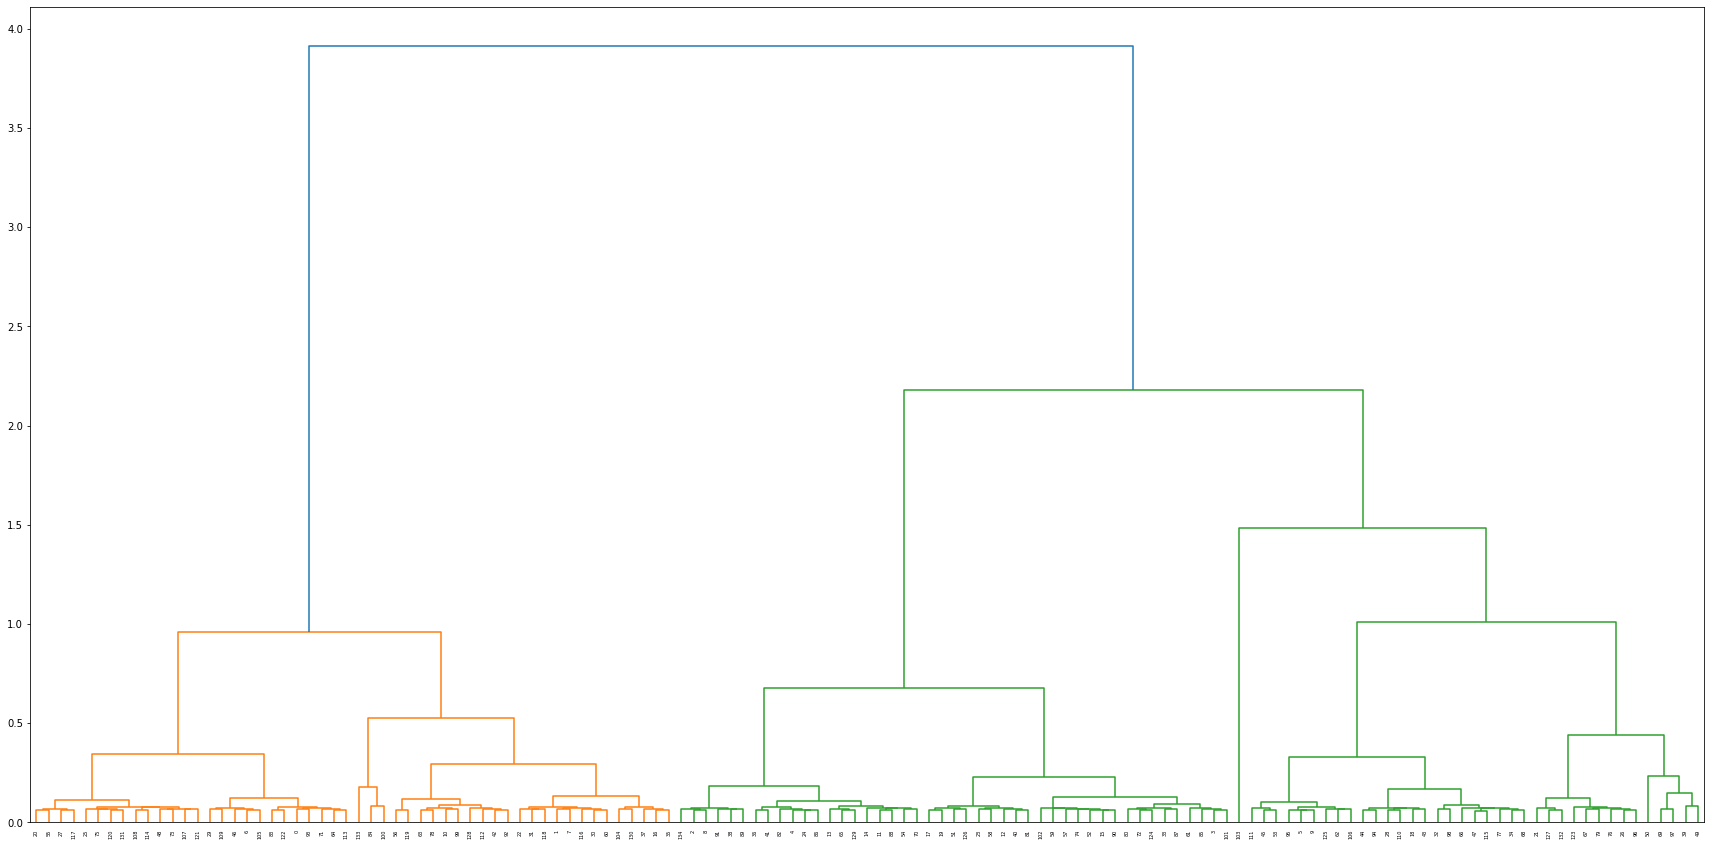

In [48]:
# デンドログラムを図示(全体)
fig = plt.figure(figsize=(30, 15), facecolor="w")
dendrogram(step_cluster)    # X軸：データラベル、Y軸：ユークリッド距離、色分けはデフォルトで最大ユークリッド距離の70%
plt.show()
fig.savefig(output_path + "dendrogram_all.png")

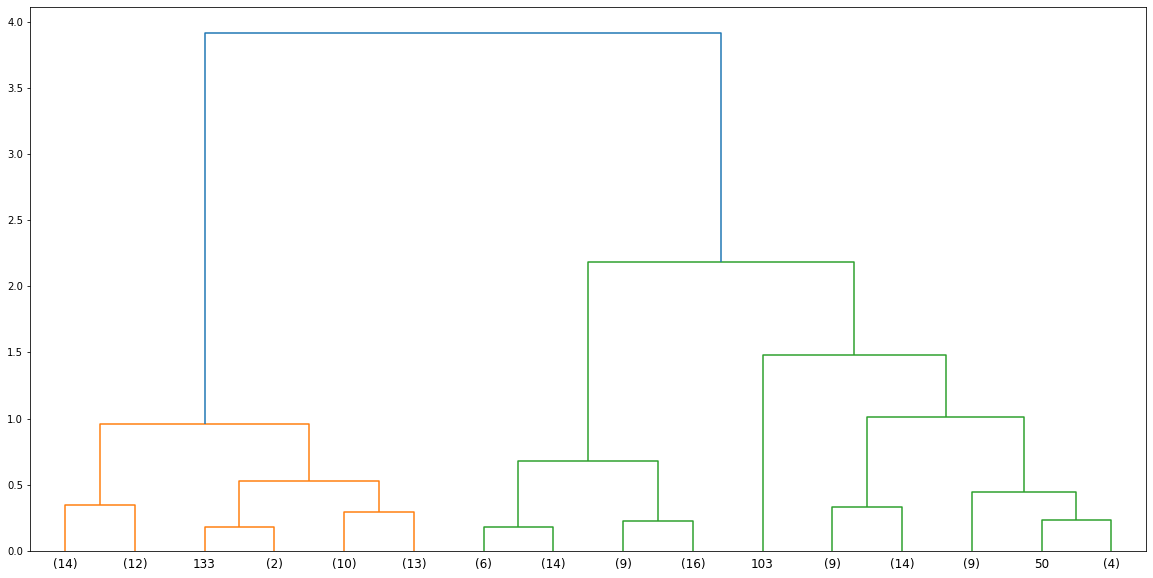

In [49]:
# デンドログラムを図示(一部)
fig = plt.figure(figsize=(20, 10), facecolor="w")
# ax = fig.add_subplot(10, 5, 10, title="デンドログラム")
dendrogram(step_cluster, truncate_mode="lastp", p=16)    # X軸：データラベル、Y軸：ユークリッド距離、色分けはデフォルトで最大ユークリッド距離の70%
plt.show()
fig.savefig(output_path + "dendrogram_lastp.png")

k=2~4あたりが良さそう

In [50]:
df[df["クラスタラベル(k=2)"] == 1]

,発表番号,発表タイトル,発表組織,発表組織カテゴリ,クラスタラベル(k=2),クラスタラベル(k=3),クラスタラベル(k=4),クラスタラベル(k=5),クラスタラベル(k=6),クラスタラベル(k=7)
0,1101,ITインフラ構築プロジェクトにおける効率化及び品質向上に向けた取り組みと有効性検証,日立製作所,企業,1,1,1,1,1,1
1,1102,基幹システムのクラウド移設におけるリスクマネジメント計画と実践,日本電気,企業,1,1,1,1,2,2
6,1107,大規模プロジェクトにおけるマトリクス組織型の現場マネジメントを経験して考えたこと,SOMPOシステムズ,企業,1,1,1,1,1,1
7,2108,大規模プロジェクトの上流工程マネジメント,日立製作所,企業,1,1,1,1,2,2
10,2111,BPOサービス開発プロジェクトにおけるプロジェクトマネジメントの留意点,日本電気,企業,1,1,1,1,2,2
16,1203,スループットのモニタリングに基づいたサービスデスク改善活動,リクルート,企業,1,1,1,1,2,2
20,1207,保守プロジェクトにおける品質向上施策の最適化について,日本アイ・ビー・エム,企業,1,1,1,1,1,1
22,2209,統計数理モデルのメタモデル化の試み,SASInstituteJapan,企業,1,1,1,1,2,2
25,2212,プロジェクト・マネジメントスキル向上事例紹介,日本アイ・ビー・エムデジタルサービス,企業,1,1,1,1,1,1
27,2214,プロジェクト・リスクの傾向と効果的なリスク・マネジメント,日本電気,企業,1,1,1,1,1,1


In [51]:
df[df["クラスタラベル(k=2)"] == 2]

,発表番号,発表タイトル,発表組織,発表組織カテゴリ,クラスタラベル(k=2),クラスタラベル(k=3),クラスタラベル(k=4),クラスタラベル(k=5),クラスタラベル(k=6),クラスタラベル(k=7)
2,1103,デジタル社会の実現に向けたデータ利活用案件における要件調整プロセスの提案,富士通,企業,2,2,2,2,3,3
3,1104,他社構築システムにおけるレガシーマイグレーション対応事例,NECソリューションイノベータ,企業,2,2,2,2,3,4
4,1105,多国籍マルチベンダーのSaaSを活用するシステム開発のプロジェクト計画と管理,日本アイ・ビー・エム,企業,2,2,2,2,3,3
5,1106,大規模ミッションクリティカルシステムにおける商用維持管理作業の品質管理に関する考察,NTTデータビジネスシステムズ,企業,2,3,3,3,4,5
8,2109,自動化ツールを活用した大量データ移行案件におけるプロジェクトマネジメントの考慮点,日本電気,企業,2,2,2,2,3,3
9,2110,ニューノーマルな働き方における中途採用者のプロジェクト受け入れ時のコミュニケーションマネジメント,日本アイ・ビー・エムデジタルサービス,企業,2,3,3,3,4,5
11,2112,パッケージ導入時の設定変更作業の取り組み,日本アイ・ビー・エム,企業,2,2,2,2,3,3
12,2113,複数の検知手段を組み合わせ実施するプロジェクトリスク点検活動,NECソリューションイノベータ,企業,2,2,2,2,3,4
13,2114,大規模開発案件輻輳プロジェクトにおけるCOCOMOモデル活用事例,日立製作所,企業,2,2,2,2,3,3
14,1201,予兆モデルを活用したプロジェクト失敗の予兆検知,日立製作所,企業,2,2,2,2,3,3


k=2でもなかなか分類が難しい・・・ 

In [52]:
def search_word(x):
    if "プロジェクト" in x and "マネジメント" in x:
        return True
    else:
        return False

df["flag"] = df["発表タイトル"].apply(search_word)
df[df["flag"]]

,発表番号,発表タイトル,発表組織,発表組織カテゴリ,クラスタラベル(k=2),クラスタラベル(k=3),クラスタラベル(k=4),クラスタラベル(k=5),クラスタラベル(k=6),クラスタラベル(k=7),flag
6,1107,大規模プロジェクトにおけるマトリクス組織型の現場マネジメントを経験して考えたこと,SOMPOシステムズ,企業,1,1,1,1,1,1,True
7,2108,大規模プロジェクトの上流工程マネジメント,日立製作所,企業,1,1,1,1,2,2,True
8,2109,自動化ツールを活用した大量データ移行案件におけるプロジェクトマネジメントの考慮点,日本電気,企業,2,2,2,2,3,3,True
9,2110,ニューノーマルな働き方における中途採用者のプロジェクト受け入れ時のコミュニケーションマネジメント,日本アイ・ビー・エムデジタルサービス,企業,2,3,3,3,4,5,True
10,2111,BPOサービス開発プロジェクトにおけるプロジェクトマネジメントの留意点,日本電気,企業,1,1,1,1,2,2,True
23,2210,PBL(探求学習)とプロジェクトマネジメントの関連性,キンドリルジャパンテクノロジーサービス,企業,2,2,2,2,3,4,True
25,2212,プロジェクト・マネジメントスキル向上事例紹介,日本アイ・ビー・エムデジタルサービス,企業,1,1,1,1,1,1,True
27,2214,プロジェクト・リスクの傾向と効果的なリスク・マネジメント,日本電気,企業,1,1,1,1,1,1,True
58,1507,大規模・高難度プロジェクトにおける上流工程マネジメントに関する考察,日本電気,企業,2,2,2,2,3,4,True
59,2508,住民情報パッケージビジネスにおける複数プロジェクトマネジメントのツールチェーン活用事例黒田一光,NECネクサソリューションズ,企業,2,2,2,2,3,4,True
